# DL: StarDist and Cellpose
[StarDist](https://github.com/stardist/stardist) and [Cellpose](https://github.com/mouseLand/cellpose) are the two most popular deep neural network to perform object
detection and segmentation. Let's try them out with `bioimageloader`.

<b style="color:red">NOTE</b> **I am not trying to make a statement through this example that one model is better than the other. What I want to demonstrate here is that both models are fabulous and may or may not perform well depending on datasets.**

<b style="color:blue">NOTE</b> This notebook requires around 4GB of GPU memory if you choose to use a GPU. If your GPU cannot cope with it then try running each model separately after reinitializaing the kernel. 

## Install dependencies and Imports
**notes about `tensorflow`**

We need `stardist`, which can be easily installed through pip (through https://pypi.org/),
but what's more important is to install `tensorflow` pkg. If you would like to use GPU,
please find a **guide in "Miscellaneous" -> ["TensorFlow installation"](../tips/tensorflow.html)** in `bioimageloader` documentation.

Additionally we install `matplotlib` and `seaborn` for plotting and `pandas`, showing
process using `tqdm`.

In [1]:
# Choose a GPU if you have multiple ones
# tensorflow tries to use all available GPU on machine by default
# Ignore this part if you are going to use CPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# disable tf warning. Not a good idea in general
# I am hiding warnings for the sake of desmonstrating this notebook
%env TF_CPP_MIN_LOG_LEVEL=3
# TF assigns all available GPU memory to its processes by default
# Come on TF seriously, we don't like this behavior and not everyone
# sets up a virtual machine with a limited GPU memory setting.
# https://github.com/tensorflow/tensorflow/issues/25138
%env TF_FORCE_GPU_ALLOW_GROWTH='true'

env: TF_CPP_MIN_LOG_LEVEL=3
env: TF_FORCE_GPU_ALLOW_GROWTH='true'


In [3]:
# #--- StarDist and Tensorflow ---# #
# !pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
# !pip install stardist # contains tools to operate STARDIST.
# !pip install gputools # improves STARDIST performances (optional)
# #--- Cellpose and PyTorch ---# #
# !pip install cellpose
# #--- etc ---# #
# !pip install matplotlib seaborn pandas tqdm

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# StarDist and TensorFlow
import tensorflow as tf
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist.matching import matching

# Cellpose and PyTorch
import torch
from cellpose import models as cellpose_models

# bioimageloader
import albumentations as A
from bioimageloader import Config, BatchDataloader
from bioimageloader.transforms import SqueezeGrayImageHWC, HWCToCHW
from bioimageloader.utils import random_label_cmap

from tqdm.notebook import tqdm

plt.rcParams['font.size'] = 9
plt.rcParams['image.interpolation'] = 'none'
cmap = random_label_cmap()

In [5]:
# setting 'TF_FORCE_GPU_ALLOW_GROWTH' does not actually limit
# gpu memory, it allows to grow. we have to manually limit memory usage
if gpus := tf.config.list_physical_devices('GPU'):
    for gpu in gpus:
        try:
            vdc = tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=2000
            )
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [vdc]
            )
        except RuntimeError as e:
            print(e)
# see what devices you have (set)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## StarDist

### Test StarDist
Let's check if everything works

I followed this guide on github page (https://github.com/stardist/stardist#pretrained-models-for-2d)

In [6]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')
# print info (I always like to know the details)
model.config.__dict__

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': [3, 3],
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': [2, 2],
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': [None, None, 1],
 'net_mask_shape': [None, None, 1],
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': [256, 256],
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': [1, 0.2],
 'train_class_weights': (1, 1),
 'train_epochs': 800,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0003,


Text(0.5, 1.0, 'prediction + input overlay')

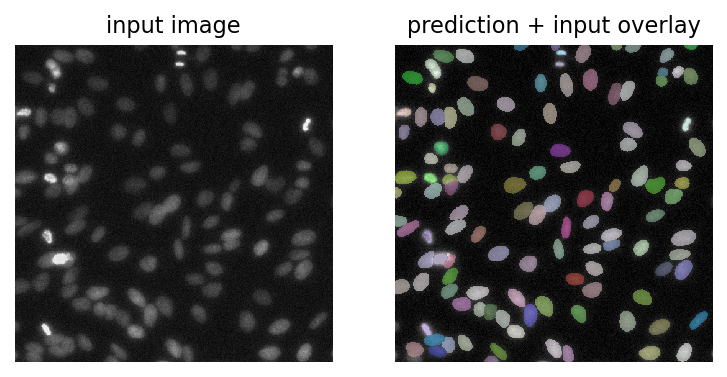

In [7]:
img = test_image_nuclei_2d() 

labels, _ = model.predict_instances(normalize(img))

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

### Test StarDist with `bioimageloader`
Once we have a working StarDist, now it is time to have some fun with `bioimageloader`!

We will resize images to manageable size (256, 256) and squeeze channels.

**Small but lengthy notes**

`bioimageloader` provides a few custom transforms compatible with `albumentations` library. 
`SqueezeGrayImageHWC` is one of them. We already converted images to grayscale,
but by default `bioimageloader` keeps its dimension to 3 channels because most
computer vision models expect RGB channels (read more about assumptions and decisions
`bioimageloader` made in the documentation). Long story short, `SqueezeGrayImageHWC`
picks only one channel out of the same 3 channels.

In [8]:
# give a path to dataset and set grayscale=True
cfg = {
    'DSB2018': {
        'root_dir': '../Data/DSB2018',
        'grayscale': True
    },
}
config = Config.from_dict(cfg)

transforms = A.Compose([
    A.Resize(256, 256),
    SqueezeGrayImageHWC()  # from (3, h, w) to (1, h, w)
])

datasets = config.load_datasets(transforms=transforms)
for dset in datasets:
    print(f'{dset.acronym:10s}: {len(dset):10d}')

DSB2018   :        670


Use `bioimageloader.BatchDataloader` to load data in batch

In [9]:
# Feel free to adjust
BATCH_SIZE = 4
NUM_WORKERS = 2

dsb2018 = datasets[0]
loader = BatchDataloader(dsb2018,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS)
iter_loader = iter(loader)

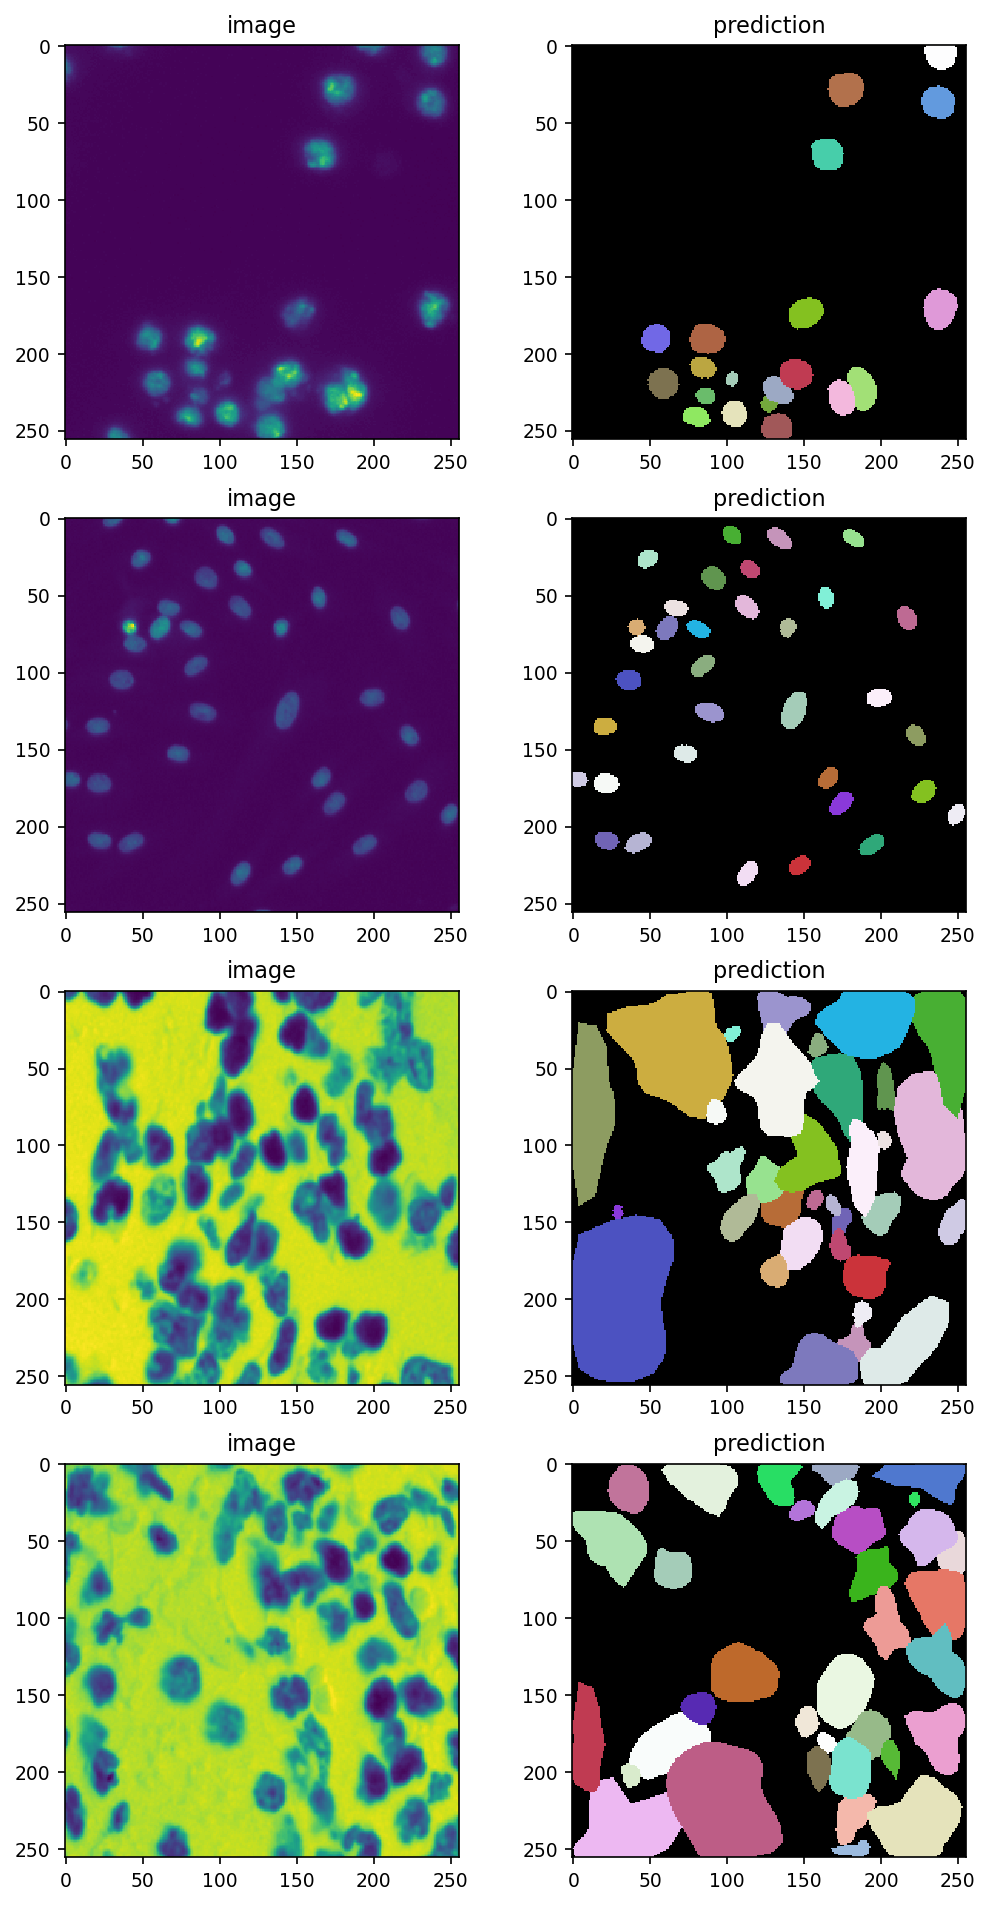

In [10]:
data = next(iter_loader)

input_image = data['image']
# will have shape (BATCH_SIZE, 256, 256)

predictions = []
for i in range(BATCH_SIZE):
    input_image_i = normalize(input_image[i])
    pred, _ = model.predict_instances(input_image_i)
    predictions.append(pred)

with plt.rc_context({'image.interpolation': 'none'}):
    fig, ax = plt.subplots(nrows=BATCH_SIZE, ncols=2,
                           figsize=[8, 4*BATCH_SIZE],
                           dpi=150)
    for i, (img, pred) in enumerate(zip(input_image, predictions)):
        ax[i, 0].imshow(img)
        ax[i, 0].set_title('image')
        ax[i, 1].imshow(pred, cmap=cmap)
        ax[i, 1].set_title('prediction')

Notice how easy it was to load data and run *StarDist* on them with `bioimageloader`? Let's have some more fun.

\*The thrid and the forth one had better be inverted. Anyway let's keep going on.

#### Evaluation
Using `bioimageloader`, we can easily iterate through all images of *DSB2018* and get
metric values. 

In [11]:
# more workers and larger batch size
BATCH_SIZE = 32
NUM_WORKERS = 8

loader = BatchDataloader(dsb2018,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS)
iter_loader = iter(loader)

In [12]:
matching_scores = []
for data in tqdm(iter_loader, total=len(loader)):
    input_image = data['image']
    gt_mask = data['mask']
    # will have shape (BATCH_SIZE, 256, 256)
    b = len(input_image)
    
    for i in range(b):
        input_image_i = normalize(input_image[i])
        gt_mask_i = gt_mask[i]
        pred_i, _ = model.predict_instances(input_image_i)
        score = matching(gt_mask_i, pred_i)
        matching_scores.append(score)

  0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
scores_df = pd.DataFrame({
    'accuracy': list(map(lambda s: s.accuracy, matching_scores)),
    'f1': list(map(lambda s: s.f1, matching_scores)),
})
scores_df

,accuracy,f1
0,0.740741,0.851064
1,0.944444,0.971429
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
665,0.923077,0.960000
666,0.761905,0.864865
667,0.894737,0.944444
668,0.846154,0.916667


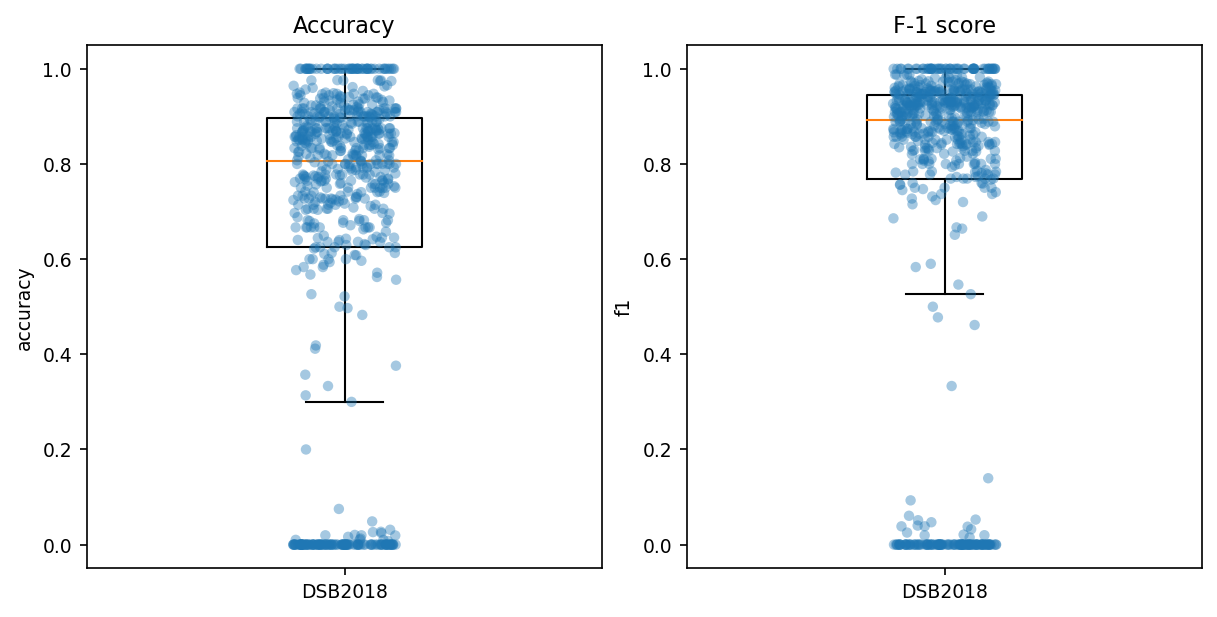

In [14]:
fig = plt.figure(constrained_layout=True, dpi=150, figsize=[8,4])

# also known as "average precision" (?)
# -> https://www.kaggle.com/c/data-science-bowl-2018#evaluation
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Accuracy')
box = ax.boxplot(x='accuracy', data=scores_df,
                 positions=[0], widths=0.3, showfliers=False)
sns.stripplot(y='accuracy', data=scores_df, alpha=0.4, ax=ax)
ax.set_xticklabels(['DSB2018'])

ax = fig.add_subplot(1, 2, 2)
ax.set_title('F-1 score')
box = ax.boxplot(x='f1', data=scores_df,
                 positions=[0], widths=0.3, showfliers=False)
sns.stripplot(y='f1', data=scores_df, alpha=0.4, ax=ax)
ax.set_xticklabels(['DSB2018']);

It performs pretty well overall!

### Scaling up evaluation
We saw that iterating *DSB2018* dataset can be easily done with `bioimageloader`.
Likewise, it is simple to iterate all other datasets in the same steps.

Below, I am loading datasets that have instance segmented mask annotation, so that
I can get object detection related metrics in the end. In addition, I am converting
color images to grayscale with `grayscale` argument, because StarDist expects that.

NOTE that we are using training dataset for *DSB2018* and *BBBC039* (the others do not have splits). Take this fact into account when you analyze results below.

In [15]:
cfg_all_collections = Config('../configs/instance_mask_collections_gray.yml')
cfg_all_collections

{'DSB2018': {'root_dir': '/home/seongbinlim/Data/DSB2018/', 'grayscale': True},
 'ComputationalPathology': {'root_dir': '/home/seongbinlim/Data/ComputationalPathology',
  'grayscale': True},
 'S_BSST265': {'root_dir': '/home/seongbinlim/Data/BioStudies'},
 'FRUNet': {'root_dir': '/home/seongbinlim/Data/FRU_processing'},
 'BBBC006': {'root_dir': '/home/seongbinlim/Data/bbbc/006/',
  'grayscale': True},
 'BBBC020': {'root_dir': '/home/seongbinlim/Data/bbbc/020', 'grayscale': True},
 'BBBC039': {'root_dir': '/home/seongbinlim/Data/bbbc/039'}}

In [16]:
transforms = A.Compose([
    A.Resize(256, 256),
    SqueezeGrayImageHWC()  # from (h, w, 3) to (h, w)
])

In [17]:
datasets = cfg_all_collections.load_datasets(transforms=transforms)
total_len = 0
for dset in datasets:
    total_len += len(dset)
    print(f'{dset.acronym:10s}: {len(dset):10d}')
print('{:10s}: {:10d}'.format('total', total_len))

DSB2018   :        670
ComPath   :         30
S_BSST265 :         79
FRUNet    :         72
BBBC006   :        768
BBBC020   :         20
BBBC039   :        150
total     :       1789


In [18]:
BATCH_SIZE = 32
NUM_WORKERS = 8

scores_df = pd.DataFrame(columns=['Name', 'Accuracy', 'F-1'])
for dset in datasets:
    print('Iterating:', dset.acronym)
    loader = BatchDataloader(dset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
    iter_loader = iter(loader)
    for batch in tqdm(iter_loader, total=len(loader)):
        input_image = batch['image']
        gt_mask = batch['mask']
        # will have shape (BATCH_SIZE, 256, 256)
        b = len(input_image)
    
        for i in range(b):
            input_image_i = normalize(input_image[i])
            gt_mask_i = gt_mask[i]
            pred_i, _ = model.predict_instances(input_image_i)
            score = matching(gt_mask_i, pred_i)
            scores_df.loc[len(scores_df)] = dset.acronym, score.accuracy, score.f1

Iterating: DSB2018


  0%|          | 0/21 [00:00<?, ?it/s]

Iterating: ComPath


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating: S_BSST265


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating: FRUNet


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating: BBBC006


  0%|          | 0/24 [00:00<?, ?it/s]

Iterating: BBBC020


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating: BBBC039


  0%|          | 0/5 [00:00<?, ?it/s]

Do some `pandas` juggling. Make each column represent a dataset and get **Accuracy**.

In [19]:
pivot_scores_acc = scores_df.pivot(columns='Name', values='Accuracy')
pivot_scores_acc

Name,BBBC006,BBBC020,BBBC039,ComPath,DSB2018,FRUNet,S_BSST265
0,NaN,NaN,NaN,NaN,0.740741,NaN,NaN
1,NaN,NaN,NaN,NaN,0.944444,NaN,NaN
2,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...
1784,NaN,NaN,0.875000,NaN,NaN,NaN,NaN
1785,NaN,NaN,0.778626,NaN,NaN,NaN,NaN
1786,NaN,NaN,0.909091,NaN,NaN,NaN,NaN
1787,NaN,NaN,0.876190,NaN,NaN,NaN,NaN


Remove NaN and serialize each column individually

In [20]:
scores_acc = []
for dset in datasets:
    scores_acc.append(pivot_scores_acc[dset.acronym].dropna().reset_index(drop=True))

Text(0.5, 1.0, 'StarDist (mAP=0.50)')

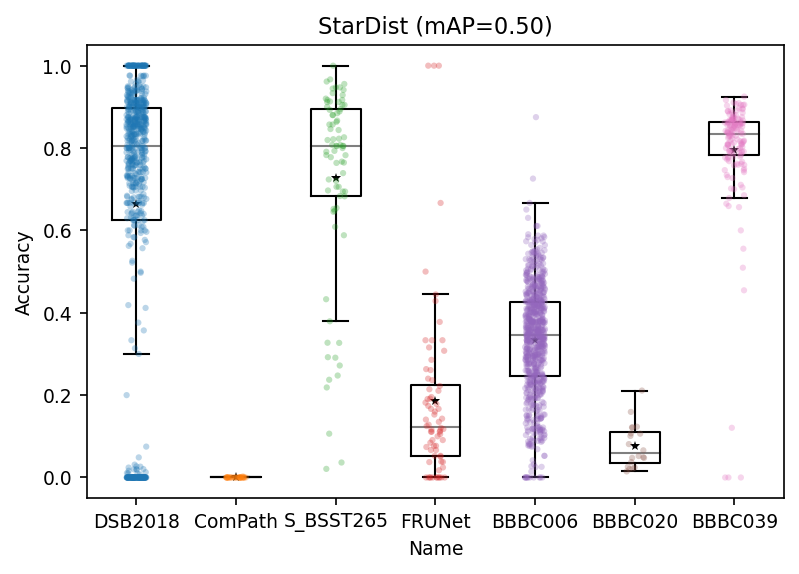

In [21]:
# props
medianprops = dict(color='k', alpha=0.5)
boxprops = dict(linestyle='-', linewidth=1)
meanpointprops = dict(marker='*',
                      markersize=5,
                      markerfacecolor='k',
                      markeredgecolor='none',
                     )


pos = list(range(len(pivot_scores_acc.columns)))  # sns default
mAP = scores_df.Accuracy.mean()

fig, ax = plt.subplots(dpi=150)
ax.boxplot(scores_acc,
           positions=pos,
           meanline=False,
           showmeans=True,
           showfliers=False,
           boxprops=boxprops,
           medianprops=medianprops,
           meanprops=meanpointprops,
          )
sns.stripplot(x='Name', y='Accuracy', data=scores_df,
              size=3, alpha=0.3, ax=ax)
# ax.set_ylim(bottom=0.4)
ax.set_title(f'StarDist (mAP={mAP:.2f})')

Overall StarDist is very impressive!

[Some More] Accuracy (average precision) value of *ComPath* is brutal. Did we do
something wrong? Check out the last section in this notebook **1.4. [Some More] Fixing(?) _ComPath_** if you are
interested.

## Cellpose

### Test Cellpose

In [22]:
model_cp = cellpose_models.Cellpose(
    gpu=True if torch.cuda.is_available() else False,
    model_type='nuclei',
)

In [23]:
img = test_image_nuclei_2d() 

with torch.no_grad():
    mask, _, _, _ = model_cp.eval(img)

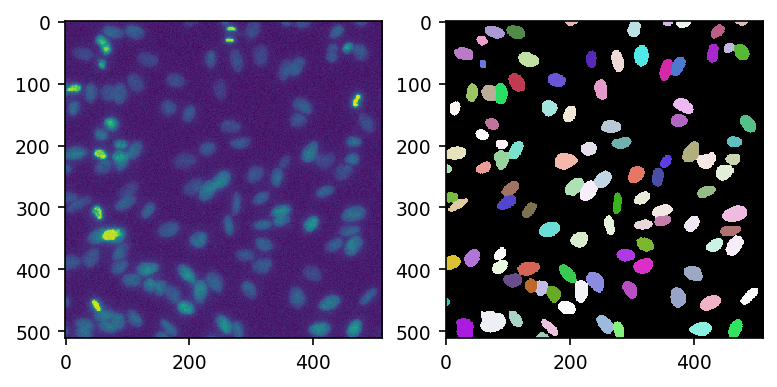

In [24]:
fig, ax = plt.subplots(ncols=2, dpi=150)
ax[0].imshow(img)
ax[1].imshow(mask, cmap=cmap)

### Evaluation with Cellpose and `bioimageloader`
Below code cells are almost copy-paste form StarDist parts except for some parts.

In [25]:
cfg_all_collections

{'DSB2018': {'root_dir': '/home/seongbinlim/Data/DSB2018/', 'grayscale': True},
 'ComputationalPathology': {'root_dir': '/home/seongbinlim/Data/ComputationalPathology',
  'grayscale': True},
 'S_BSST265': {'root_dir': '/home/seongbinlim/Data/BioStudies'},
 'FRUNet': {'root_dir': '/home/seongbinlim/Data/FRU_processing'},
 'BBBC006': {'root_dir': '/home/seongbinlim/Data/bbbc/006/',
  'grayscale': True},
 'BBBC020': {'root_dir': '/home/seongbinlim/Data/bbbc/020', 'grayscale': True},
 'BBBC039': {'root_dir': '/home/seongbinlim/Data/bbbc/039'}}

Cellpose expect image batch to have (b, 3, h, w) shape. Remember that `bioimageloader`
returns (b, h, w, 3)? We will reorder shape to match what Cellpose requires by using
`bioimageloader.transforms.HWCToCHW`.

In [26]:
transforms = A.Compose([
    A.Resize(256, 256),
    # SqueezeGrayImageHWC()  # from (h, w, 3) to (h, w)
    HWCToCHW(),  # NEW, from (h, w, 3) to (3, h, w)
])

In [27]:
datasets = cfg_all_collections.load_datasets(transforms=transforms)
total_len = 0
for dset in datasets:
    total_len += len(dset)
    print(f'{dset.acronym:10s}: {len(dset):10d}')
print('{:10s}: {:10d}'.format('total', total_len))

DSB2018   :        670
ComPath   :         30
S_BSST265 :         79
FRUNet    :         72
BBBC006   :        768
BBBC020   :         20
BBBC039   :        150
total     :       1789


We will go through the same steps as StarDist

Notice that

- Cellpose allows batch processing

    Don't have to iterate each entry in batch
    
- Slower than StarDist because of `net_avg`

    You may think that batch processing should allow faster execution, but it is not
    because of `net_avg`. It is an ensemble idea, common in machine learning.
    Cellpose suggests to opt in `net_avg`, which runs 4 differenct models and
    aggregates their results.

In [28]:
BATCH_SIZE = 32
NUM_WORKERS = 8

scores_df = pd.DataFrame(columns=['Name', 'Accuracy', 'F-1'])
for dset in datasets:
    print('Iterating:', dset.acronym)
    loader = BatchDataloader(dset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
    iter_loader = iter(loader)
    for batch in tqdm(iter_loader, total=len(loader)):
        input_image = batch['image']
        gt_mask = batch['mask']
        # will have shape (BATCH_SIZE, 256, 256)
        b = len(input_image)
        with torch.no_grad():
            pred_mask, _, _, _ = model_cp.eval(input_image,
                                               normalize=True,
                                               net_avg=True)
        for i in range(b):
            gt_mask_i = gt_mask[i]
            pred_i = pred_mask[i]
            score = matching(gt_mask_i, pred_i)
            scores_df.loc[len(scores_df)] = dset.acronym, score.accuracy, score.f1    

Iterating: DSB2018


  0%|          | 0/21 [00:00<?, ?it/s]

Iterating: ComPath


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating: S_BSST265


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating: FRUNet


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating: BBBC006


  0%|          | 0/24 [00:00<?, ?it/s]

Iterating: BBBC020


  0%|          | 0/1 [00:00<?, ?it/s]

Iterating: BBBC039


  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
scores_df

,Name,Accuracy,F-1
0,DSB2018,0.714286,0.833333
1,DSB2018,0.861111,0.925373
2,DSB2018,0.000000,0.000000
3,DSB2018,0.000000,0.000000
4,DSB2018,0.000000,0.000000
...,...,...,...
1784,BBBC039,0.791667,0.883721
1785,BBBC039,0.732824,0.845815
1786,BBBC039,0.830769,0.907563
1787,BBBC039,0.764151,0.866310


In [30]:
pivot_scores_acc = scores_df.pivot(columns='Name', values='Accuracy')
pivot_scores_acc

Name,BBBC006,BBBC020,BBBC039,ComPath,DSB2018,FRUNet,S_BSST265
0,NaN,NaN,NaN,NaN,0.714286,NaN,NaN
1,NaN,NaN,NaN,NaN,0.861111,NaN,NaN
2,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...
1784,NaN,NaN,0.791667,NaN,NaN,NaN,NaN
1785,NaN,NaN,0.732824,NaN,NaN,NaN,NaN
1786,NaN,NaN,0.830769,NaN,NaN,NaN,NaN
1787,NaN,NaN,0.764151,NaN,NaN,NaN,NaN


Remove NaN and serialize each column individually

In [31]:
scores_acc = []
for dset in datasets:
    scores_acc.append(pivot_scores_acc[dset.acronym].dropna().reset_index(drop=True))

Text(0.5, 1.0, 'Cellpose (mAP=0.34)')

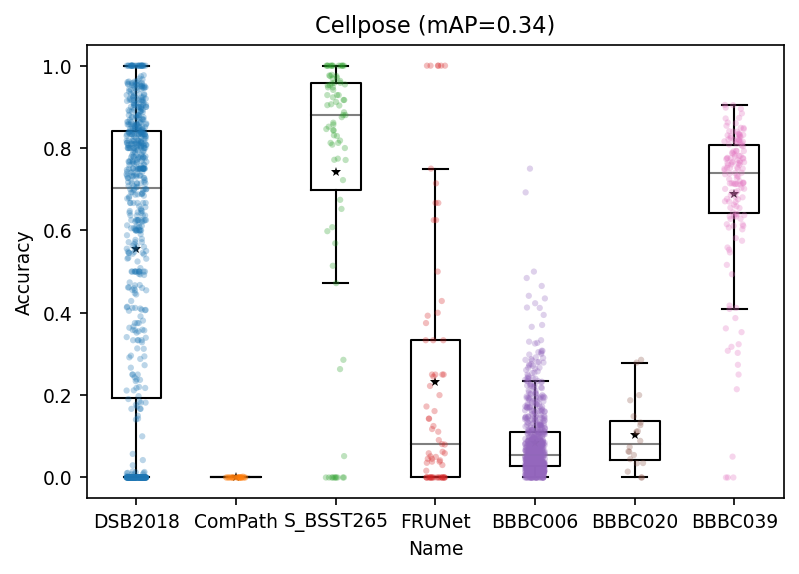

In [32]:
# props
medianprops = dict(color='k', alpha=0.5)
boxprops = dict(linestyle='-', linewidth=1)
meanpointprops = dict(marker='*',
                      markersize=5,
                      markerfacecolor='k',
                      markeredgecolor='none',
                     )


pos = list(range(len(pivot_scores_acc.columns)))  # sns default
mAP = scores_df.Accuracy.mean()

fig, ax = plt.subplots(dpi=150)
ax.boxplot(scores_acc,
           positions=pos,
           meanline=False,
           showmeans=True,
           showfliers=False,
           boxprops=boxprops,
           medianprops=medianprops,
           meanprops=meanpointprops,
          )
sns.stripplot(x='Name', y='Accuracy', data=scores_df,
              size=3, alpha=0.3, ax=ax)
# ax.set_ylim(bottom=0.4)
ax.set_title(f'Cellpose (mAP={mAP:.2f})')

Again as I mentioned at the beginning of this notbook, there is no winner!
Cellpose does better in some cases and does not in others.
Depending on your images and tasks, you decide which to use, what pre-/post-processes
are needed on top of that, how to normalize your data so that they get fit to these
models, etc.

You definitely want to analyze and get statistics of your data before you do anything
on them, and now you have `bioimageloader` that could make all these steps so
much easier and much painless!

## [Some More] Fixing(?) *ComPath*
This [overview table](../_static/table_maskdataset.html) is a helpful one. You could
see from the sample images that *ComPath* is, first of all, H&E histopathology images,
which are distinct from the others. And images are dense and have high resolution
(1000, 1000). So resizing them to (256, 256) may have not been a wise choice for
*ComPath*.

Let's define a new set of transforms for *ComPath*. We are going to do two things:

1. Remove `Resize()` so that *StarDist* processes large dense images of *ComPath*

    *StarDist* is a family of FCN (Fully Connected Neural network), which has
    size-invariant property meaning that it can take any size of input and return
    ouput whose size is the same as that of input. So we can just get rid of Resize.
    
2. `albumentation.InvertImg(p=1.0)`

    It will invert pixel values with 100% probability (`p=1.0`). It will make H&E
    stained images look more like the rest.

In [33]:
cfg_all_collections

{'DSB2018': {'root_dir': '/home/seongbinlim/Data/DSB2018/', 'grayscale': True},
 'ComputationalPathology': {'root_dir': '/home/seongbinlim/Data/ComputationalPathology',
  'grayscale': True},
 'S_BSST265': {'root_dir': '/home/seongbinlim/Data/BioStudies'},
 'FRUNet': {'root_dir': '/home/seongbinlim/Data/FRU_processing'},
 'BBBC006': {'root_dir': '/home/seongbinlim/Data/bbbc/006/',
  'grayscale': True},
 'BBBC020': {'root_dir': '/home/seongbinlim/Data/bbbc/020', 'grayscale': True},
 'BBBC039': {'root_dir': '/home/seongbinlim/Data/bbbc/039'}}

In [34]:
transforms = A.Compose([
    A.Resize(256, 256),
    SqueezeGrayImageHWC()  # from (h, w, 3) to (h, w)
])
transforms_compath = A.Compose([
    A.InvertImg(p=1.0),
    SqueezeGrayImageHWC()  # from (h, w, 3) to (h, w)
])

cfg_transforms = {
    'DSB2018': transforms,
    'ComputationalPathology': transforms_compath,  # needs extra care
    'S_BSST265': transforms,
    'FRUNet': transforms,
    'BBBC006': transforms,
    'BBBC020': transforms,
    'BBBC039': transforms,
}

In [35]:
# we only need ComPath
datasets = cfg_all_collections.load_datasets(transforms=cfg_transforms)
dset = datasets[1]
print(dset)

ComPath


In [36]:
BATCH_SIZE = 32
NUM_WORKERS = 8

fix_scores_df = pd.DataFrame(columns=['Name', 'Accuracy', 'F-1'])
# for dset in datasets:
print(dset.acronym)
loader = BatchDataloader(dset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS)
iter_loader = iter(loader)
for batch in tqdm(iter_loader, total=len(loader)):
    input_image = batch['image']
    gt_mask = batch['mask']
    # will have shape (BATCH_SIZE, 256, 256)
    b = len(input_image)

    for i in range(b):
        input_image_i = normalize(input_image[i])
        gt_mask_i = gt_mask[i]
        pred_i, _ = model.predict_instances(input_image_i)
        score = matching(gt_mask_i, pred_i)
        fix_scores_df.loc[len(fix_scores_df)] = dset.acronym, score.accuracy, score.f1

ComPath


  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
beforefix_scores = pivot_scores_acc['ComPath'].dropna().reset_index(drop=True)
beforefix_scores.head()
# before, almost all values were close to zero

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ComPath, dtype: float64

In [38]:
fix_scores_df.head()
# new metrics look much better. they are not zeros!

,Name,Accuracy,F-1
0,ComPath,0.382353,0.553191
1,ComPath,0.394756,0.566057
2,ComPath,0.348028,0.516351
3,ComPath,0.133023,0.234811
4,ComPath,0.093212,0.170528


Text(0.5, 0.98, 'ComPath')

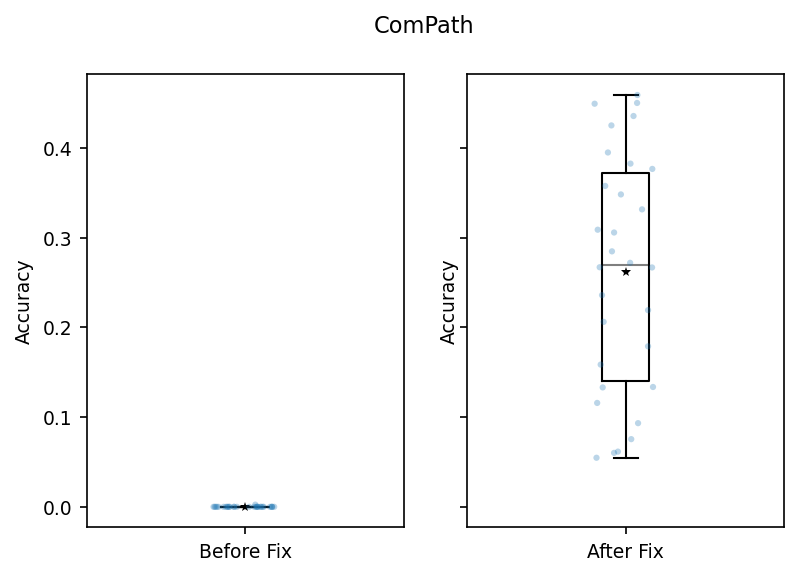

In [39]:
# props
medianprops = dict(color='k', alpha=0.5)
boxprops = dict(linestyle='-', linewidth=1)
meanpointprops = dict(marker='*',
                      markersize=5,
                      markerfacecolor='k',
                      markeredgecolor='none',
                     )



pos = [0]  # sns default
# mAP = scores_df.Accuracy.mean()

fig, ax = plt.subplots(ncols=2, sharey=True, dpi=150)
ax[0].boxplot(beforefix_scores,
           positions=pos,
           meanline=False,
           showmeans=True,
           showfliers=False,
           boxprops=boxprops,
           medianprops=medianprops,
           meanprops=meanpointprops,
          )
sns.stripplot(y=beforefix_scores,
              size=3, alpha=0.3, ax=ax[0])
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(['Before Fix'])

ax[1].boxplot(fix_scores_df.Accuracy,
           positions=pos,
           meanline=False,
           showmeans=True,
           showfliers=False,
           boxprops=boxprops,
           medianprops=medianprops,
           meanprops=meanpointprops,
          )
sns.stripplot(x='Name', y='Accuracy', data=fix_scores_df,
              size=3, alpha=0.3, ax=ax[1])
ax[1].set_xticklabels(['After Fix'])
ax[1].set_xlabel('')
fig.suptitle('ComPath')

We can visualize actual predictions

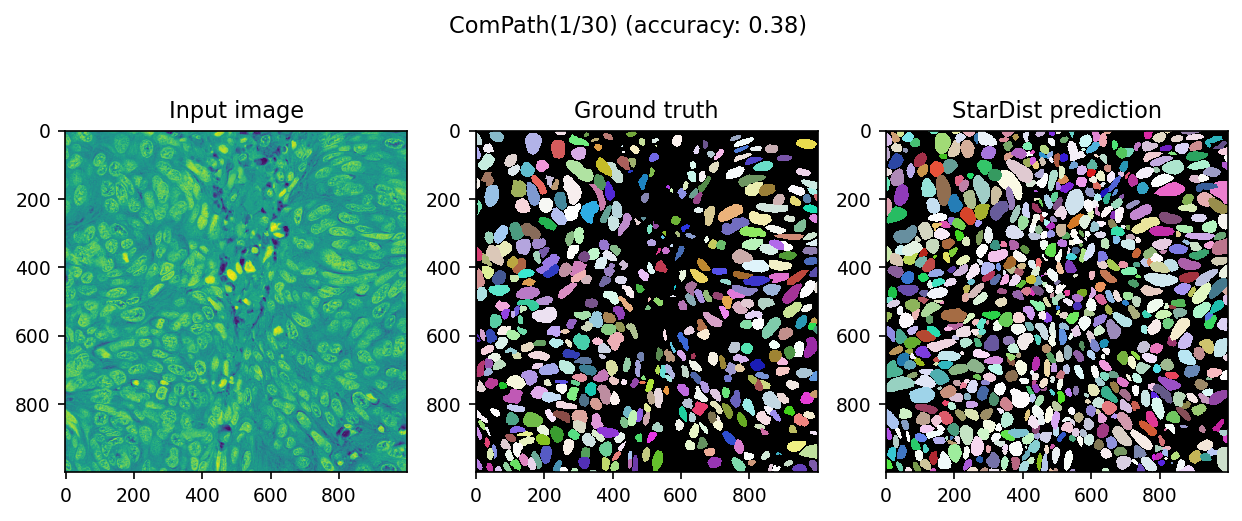

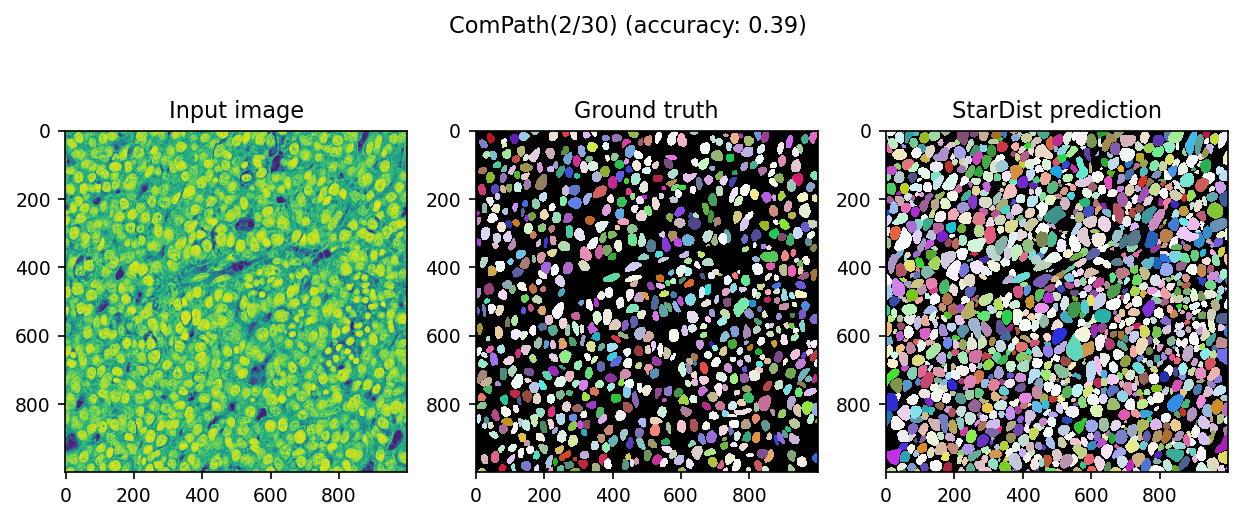

In [40]:
# sample first two paris
for ind in range(2):
    data = dset[ind]
    image = data['image']
    mask = data['mask']
    pred, _ = model.predict_instances(normalize(image))
    score = matching(mask, pred)

    with plt.rc_context({'image.interpolation': 'none'}):
        fig, ax = plt.subplots(ncols=3, figsize=[10, 4], dpi=150)
        fig.suptitle(f'ComPath({ind+1}/{len(dset)}) (accuracy: {score.accuracy:.2f})')
        ax[0].imshow(image)
        ax[0].set_title('Input image')
        ax[1].imshow(mask, cmap=cmap)
        ax[1].set_title('Ground truth')
        ax[2].imshow(pred, cmap=cmap)
        ax[2].set_title('StarDist prediction')

We fixed(?) it from almost zero prediction!